# Active Learning with GraNd (Gradient Normed) Sampling

*Authors: Sahika Betul Yayli, MD*

## Introduction to Active Learning

Active Learning is a powerful technique in machine learning that helps improve model performance while reducing the need for excessive manual labeling. Instead of training a model on a fully labeled dataset, Active Learning allows the model to decide which data points should be labeled, focusing on the most informative samples.

This approach makes the labeling process more efficient by reducing the number of labels needed while still maintaining (or even improving) performance. It’s particularly useful in cases where labeling data is expensive or time-consuming, such as medical imaging, speech recognition, and other domains requiring expert annotation.

## The GraNd (Gradient Normed) Method

GraNd is a sampling technique used in active learning. It assigns a relevance score to each sample based on the average gradient of the loss. The method typically uses the gradients of the parameters in the penultimate layer of the network (just before the linear layer that yields the class probabilities).

The penultimate layer is chosen for several reasons:
1. It represents high-level features learned by the model.
2. Gradients at this layer are more informative about the model's learning process than the final layer.
3. The final layer often includes a softmax activation, which can mask the true uncertainty of the model.
4. Using the penultimate layer makes the method more generalizable across different model architectures.

Let's implement the GraNd method using PyTorch:

# Step-by-Step Application of GraNd Sampling on MNIST

This initial step performs two essential tasks:

1. **Imports necessary libraries** such as PyTorch, NumPy, and Matplotlib for deep learning, data handling, and visualization.
2. **Ensures reproducibility** by setting fixed random seeds for PyTorch, NumPy, and Python’s `random` module.

Reproducibility is critical in machine learning experiments to ensure consistent results across runs.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reproducibility
seed = 61
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In this step, we define a simple **Convolutional Neural Network (CNN)** called `SimpleCNN` to classify MNIST digits.

The model consists of:
- **Two convolutional layers** followed by ReLU activations and a max pooling operation
- **One hidden fully connected (dense) layer** with 128 units
- **An output layer** with 10 units (one for each digit class)

This architecture is lightweight yet powerful enough to effectively learn from MNIST.

In [2]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Here, we load the **MNIST dataset**, which consists of 60,000 training and 10,000 test grayscale images of handwritten digits (0–9).

Key steps:
- We use `torchvision.datasets.MNIST` to download and load the data.
- Images are transformed into tensors using `transforms.ToTensor()`.
- A `DataLoader` is created for the **test set** to enable efficient batch-wise evaluation later.

Note: The training DataLoader will be created dynamically depending on which subset of data (e.g., 10%, GraNd, etc.) is used in each experiment.

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In this step, we define two key utility functions used throughout our experiments:

- **`train_model()`**:  
  Trains a given model for a specified number of epochs using the Adam optimizer and cross-entropy loss.  
  The model is trained on a specified `DataLoader` (e.g., random 10%, GraNd samples, full data, etc.).

- **`evaluate_model()`**:  
  Evaluates a trained model’s classification accuracy on a given test set.

These reusable functions enable consistent model training and performance comparison.

In [4]:
def train_model(model, train_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for _ in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    return model

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


This function calculates GraNd (Gradient Norm) scores **without requiring ground truth labels**, making it suitable for **unlabeled data** in active learning pipelines.

As stated in our objective, the goal is to **minimize manual labeling effort** while still training a model that performs well.  
By estimating how informative each sample is without using labels, we can selectively annotate only the most impactful data points.

How it works:
- The model makes predictions for each input sample.
- The entropy of the prediction is used as a proxy for loss, instead of using true labels.
$$\text{Entropy Loss} = -\sum p(x) \log p(x)$$
- The gradient of the entropy-based loss is backpropagated.
- The **L2 norm of the gradient** is computed and used as the GraNd score.

Samples with higher gradient norms are assumed to be more informative and are prioritized for annotation in active learning settings.


In [ ]:
def compute_grand_scores(model, data_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scores = []

    penultimate_params = list(model.fc1.parameters())

    for data, _ in tqdm(data_loader):
        data = data.to(device)

        for i in range(data.size(0)):
            model.zero_grad()
            input_i = data[i].unsqueeze(0)
            output_i = model(input_i)

            prob = F.softmax(output_i, dim=1)
            entropy_loss = -torch.sum(prob * torch.log(prob + 1e-8))

            entropy_loss.backward()

            grad_norm = sum(
                (p.grad**2).sum().item()
                for p in penultimate_params
                if p.grad is not None
            )
            scores.append(grad_norm)

    return np.array(scores)

## Training `model_active_base10` — Random 10% Seed Set from Training Dataset

This model is trained using a randomly selected **10% subset** of the MNIST training dataset.  
It acts as the **initial baseline model** in our active learning pipeline, representing the starting point before applying any sampling strategy.

Here, we split the training dataset into two parts:

- **Seed Set (10%)**: A randomly selected 10% of the full training dataset. This will be used to train the initial baseline model.
- **Remaining Set (90%)**: The rest of the data, which will later be ranked using GraNd scores or sampled randomly.

This split simulates a typical **active learning setting**, where we only start with a small amount of labeled data, and selectively acquire more samples over time.

The seed set allows us to train an initial model, which is then used to compute GraNd scores on the remaining unlabeled data.

In [6]:
num_total = len(train_dataset)
num_seed = num_total * 10 // 100  # 10%

indices = np.arange(num_total)
np.random.shuffle(indices)
seed_indices = indices[:num_seed]
remaining_indices = indices[num_seed:]

seed_dataset = Subset(train_dataset, seed_indices)
remaining_dataset = Subset(train_dataset, remaining_indices)

In [7]:
seed_loader = DataLoader(seed_dataset, batch_size=64, shuffle=True)

model_active_base10 = SimpleCNN()
model_active_base10 = train_model(model_active_base10, seed_loader, epochs=5)
acc_base = evaluate_model(model_active_base10, test_loader)
print(f"Test Accuracy of model_active_base10: {acc_base:.4f}")

Test Accuracy of model_active_base10: 0.9692


## Training `model_active_grand10` — Random 10% Seed Set + Top 10% from Remaining Data by GraNd Score

Now that we have trained our initial baseline model, we use it to compute **GraNd scores** on the remaining 90% of the training data.

Why?
- The goal is to identify which unlabeled samples are **most informative** for the model.
- We use the previously defined `compute_grand_scores()` function to score each sample based on its **gradient norm**.

These scores allow us to rank the remaining dataset and select a subset of data that will most improve the model if labeled and included in training.


In [8]:
remaining_loader = DataLoader(remaining_dataset, batch_size=1, shuffle=False)
grand_scores = compute_grand_scores(model_active_base10, remaining_loader)

100%|██████████| 54000/54000 [01:08<00:00, 789.72it/s]


We then sort the samples based on their GraNd scores and select the top 10% most informative samples.

In [9]:
num_grand = len(seed_indices) * 90 // 100  
top_indices = np.argsort(grand_scores)[-num_grand:]
grand_selected_indices = [remaining_indices[i] for i in top_indices] # 9% of total dataset ~ 5400

grand_dataset = Subset(train_dataset, list(seed_indices) + grand_selected_indices)
grand_loader = DataLoader(grand_dataset, batch_size=64, shuffle=True)

In [10]:
model_active_grand10 = SimpleCNN()
model_active_grand10 = train_model(model_active_grand10, grand_loader, epochs=5)
acc_grand = evaluate_model(model_active_grand10, test_loader)
print(f"Test Accuracy of model_active_grand10: {acc_grand:.4f}")

Test Accuracy of model_active_grand10: 0.9868


## Training `model_supervised_random19` — Random 10% Seed Set + Random 10% from Remaining Training Data


To provide a fair baseline against `model_active_grand10`, this model is trained on the **same total amount of data (19%)**,  
but the additional 9% is selected **randomly** from the remaining training samples instead of using GraNd scores.

We combine these random samples with the original seed set to create the `random19_dataset`.

This dataset will be used to train `model_supervised_random19`, allowing us to isolate the effect of **GraNd vs. random** sample selection with the **same data budget** (total 19%).

This is a critical control group for measuring the true value of the GraNd strategy.

In [11]:
# All indices excluding the seed
all_indices = set(np.arange(len(train_dataset)))
non_seed_indices = list(all_indices - set(seed_indices))

# Randomly select 5400 from the remaining
random_selected_indices = np.random.choice(non_seed_indices, size=num_grand, replace=False)
random19_indices = np.concatenate([seed_indices, random_selected_indices])

random19_dataset = Subset(train_dataset, random19_indices)
random19_loader = DataLoader(random19_dataset, batch_size=64, shuffle=True)

In [12]:
model_supervised_random19 = SimpleCNN()
model_supervised_random19 = train_model(model_supervised_random19, random19_loader, epochs=5)
acc_random19 = evaluate_model(model_supervised_random19, test_loader)
print(f"Test Accuracy of model_supervised_random19: {acc_random19:.4f}")

Test Accuracy of model_supervised_random19: 0.9790


## Training `model_supervised_full` — Full Training Dataset (100%)

To establish an upper-bound performance reference, we train `model_supervised_full` using the **entire MNIST training dataset**.

- This model does **not use any sampling or active learning strategy**.
- It represents the best performance we can expect with full supervision.

After training, we evaluate its accuracy on the test set and use it to compare with the other models trained on partial data.

This model helps answer: “How close can active learning get to full-supervision performance?”

In [13]:
full_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [14]:
model_supervised_full = SimpleCNN()
model_supervised_full = train_model(model_supervised_full, full_loader, epochs=5)
acc_full = evaluate_model(model_supervised_full, test_loader)
print(f"Test Accuracy of model_supervised_full: {acc_full:.4f}")

Test Accuracy of model_supervised_full: 0.9921


## 📊 Accuracy Comparison of All Models

This section visualizes the performance of all four trained models by comparing their test set accuracy.

The bar chart allows us to assess how close GraNd-based active learning gets to full supervision — and whether it outperforms random selection with the same data budget.

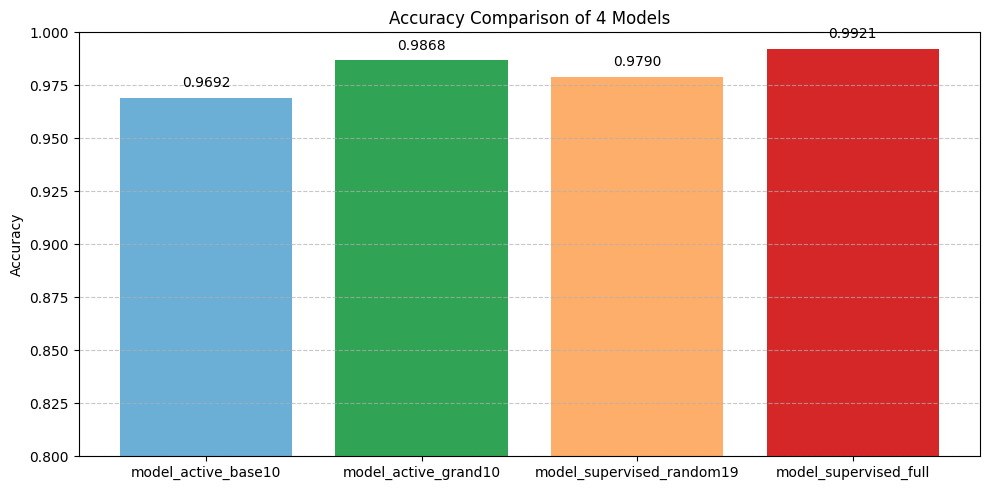

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

model_names = [
    'model_active_base10', 
    'model_active_grand10', 
    'model_supervised_random19', 
    'model_supervised_full'
]

accuracies = [
    acc_base, 
    acc_grand, 
    acc_random19, 
    acc_full
]

plt.figure(figsize=(10, 5))
bars = plt.bar(model_names, accuracies, color=['#6baed6', '#31a354', '#fdae6b', '#d62728'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of 4 Models')

# Annotate bars with accuracy values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 📊 Accuracy Improvement Analysis

In [16]:
print(f"GraNd vs Random (same data): {acc_grand - acc_random19:.4f}")
print(f"GraNd vs Base10 only:        {acc_grand - acc_base:.4f}")
print(f"GraNd vs Full Supervised:    {acc_full - acc_grand:.4f}")

GraNd vs Random (same data): 0.0078
GraNd vs Base10 only:        0.0176
GraNd vs Full Supervised:    0.0053


## 📈 Discussion of Accuracy Differences

Based on the printed results above:

- **GraNd vs Random (same data): +0.0078**  
  Even though both models were trained on the same amount of data (19%), GraNd selection achieved better accuracy.  
  ✅ This suggests that GraNd identifies more **informative samples** than random selection.

- **GraNd vs Base10 only: +0.0176**  
  Adding GraNd-selected samples to the base model improves performance significantly.  
  ✅ GraNd helps the model generalize better with only a modest data increase.

- **GraNd vs Full Supervised: -0.0053**  
  GraNd-trained model almost reaches the performance of the model trained on the full dataset.  
  ✅ This demonstrates how **efficient** active learning can be in reducing data requirements.

## 💡 Key Insight:
With GraNd, you can reach **near-maximum performance** with just a **fraction of the dataset** — ideal for scenarios with limited labeled data.


# Applying GraNd Sampling to nnU-Net

In this section, we demonstrate how the **GraNd active learning strategy** can be extended to **3D medical imaging tasks** using `nnU-Net`, a popular framework for volumetric segmentation — and how you can apply it directly to your **remaining unlabeled data using a pretrained nnU-Net model**.

Unlike classification tasks like MNIST, medical images (e.g., MRI/CT) are processed as 3D volumes and require specialized preprocessing and architecture.

🎯 Goal:

Compute **GraNd scores** for unlabeled 3D NIfTI images to select the most informative volumes for manual annotation — reducing labeling effort in medical segmentation.


We load a pretrained nnU-Net model and identify the **penultimate convolutional layer** to compute gradient norms from.

In [ ]:
import os
import pandas as pd
import nibabel as nib
import torch.nn.functional as F
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_FOLDER = "/path/to/training_images_folder"
MODEL_FOLDER = "/path/to/trained_model_folder"
CHECKPOINT_NAME = "checkpoint_name"

predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_device=True,
    device=torch.device("cuda"),
    verbose=False,
    verbose_preprocessing=False,
    allow_tqdm=True
)

predictor.initialize_from_trained_model_folder(
    CHECKPOINT_NAME,
    use_folds="all",
    checkpoint_name=CHECKPOINT_NAME
)

penultimate_layer = predictor.network.decoder.stages[-1].convs[-1].conv

`load_and_preprocess_nifti` helper function reads 3D NIfTI medical images, normalizes the intensity values,  
and resamples each volume to a fixed patch size expected by the model.

It prepares the data for use in GraNd scoring by:
- Converting it to a PyTorch tensor
- Normalizing it (zero mean, unit variance)
- Resizing to the model’s input shape

In [ ]:
def load_and_preprocess_nifti(image_path, device, patch_size):
    # Load the NIfTI file
    nii = nib.load(image_path)
    image_data = nii.get_fdata().astype(np.float32)

    # Convert to torch tensor and add batch and channel dimensions: [1, 1, D, H, W]
    image_tensor = torch.from_numpy(image_data).unsqueeze(0).unsqueeze(0).to(device)

    # Normalize the image (zero mean, unit variance)
    image_tensor = (image_tensor - image_tensor.mean()) / (image_tensor.std() + 1e-8)

    # Resize to fixed patch size (using trilinear interpolation)
    image_tensor = F.interpolate(image_tensor, size=patch_size, mode='trilinear', align_corners=False)

    return image_tensor, nii.affine

We use an unsupervised loss (entropy) and backpropagate it through the penultimate layer for each unlabeled NIfTI volume:

In [ ]:
# Fixed patch size for resampling
patch_size = (128, 128, 128)

def compute_grand_scores(model, image_files, patch_size, device=None):
    model.eval()
    scores = []
    filenames = []

    if device is None:
        device = next(model.parameters()).device
    model.to(device)

    for img_file in tqdm(image_files):
        img_name = os.path.basename(img_file)
        filenames.append(img_name)

        try:
            image_tensor, _ = load_and_preprocess_nifti(img_file, device, patch_size)
            with torch.set_grad_enabled(True):
                prediction = model(image_tensor)
                loss = -torch.sum(F.softmax(prediction, dim=1) * F.log_softmax(prediction, dim=1))
                grads = torch.autograd.grad(loss, penultimate_layer.weight, retain_graph=True)[0]
                grad_norm = grads.norm(2).item()
                scores.append(grad_norm)
        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")
            scores.append(0.0)

    return scores, filenames


This line retrieves and sorts all `.nii.gz` files from the directory specified by `IMAGE_FOLDER`.  
These files represent unlabeled 3D medical images (e.g., MRI/CT scans) that will be used for GraNd scoring.  
Sorting ensures a consistent order during processing and later selection steps.

In [ ]:
image_files = sorted([os.path.join(IMAGE_FOLDER, f) for f in os.listdir(IMAGE_FOLDER) if f.endswith(".nii.gz")])

This step uses the pretrained nnU-Net model to compute **GraNd scores** for each unlabeled NIfTI image in `image_files`.

In [ ]:
grand_scores, filenames = compute_grand_scores(predictor.network, image_files, patch_size, device=device)

100%|██████████| 77/77 [00:04<00:00, 18.03it/s]


After computing GraNd scores, this step sorts all unlabeled images in descending order based on their score values.

- The top-k most informative samples (default `k=10`) are printed to the screen.
- These examples are assumed to provide the greatest potential for improving model performance if annotated.
- The results are saved to a CSV file named `most_informative_examples.csv`, containing the filename and corresponding GraNd score.

This ranked list can be used to guide manual annotation efforts in an efficient, data-driven way.

In [ ]:
# Sort images by their GraNd scores and save top results
if len(grand_scores) > 0:
    results = list(zip(filenames, grand_scores))
    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    top_k = 10
    top_results = sorted_results[:min(top_k, len(sorted_results))]

    print(f"\nTop {len(top_results)} most informative examples:")
    for i, (filename, score) in enumerate(top_results):
        print(f"{i+1}. {filename} - GraNd Score: {score:.4f}")

    # Save results to a CSV file
    df_results = pd.DataFrame(top_results, columns=["Filename", "GraNd Score"])
    output_csv = "most_informative_examples.csv"
    df_results.to_csv(output_csv, index=False)

    print(f"\nResults saved to '{output_csv}'")

else:
    print("No scores were calculated successfully.")


Top 10 most informative examples:
1. 3144213-20220920-7_0000.nii.gz - GraNd Score: 16884.3047
2. 3661601-20220803-14_0000.nii.gz - GraNd Score: 9458.2773
3. 12609843-20200609-8_0000.nii.gz - GraNd Score: 7418.3120
4. 3939741-20150821-9_0000.nii.gz - GraNd Score: 3501.4294
5. 7254639-20111107-102_0000.nii.gz - GraNd Score: 2782.0569
6. 7473639-20140828-2_0000.nii.gz - GraNd Score: 2734.0901
7. 7385294-20170501-14_0000.nii.gz - GraNd Score: 2483.4429
8. 7393730-20150408-9_0000.nii.gz - GraNd Score: 1976.5645
9. 7121295-20210419-5_0000.nii.gz - GraNd Score: 1921.9559
10. 7291065-20160421-6_0000.nii.gz - GraNd Score: 1893.6211

Results saved to 'most_informative_examples.csv'


# Conclusion

In this notebook, you implemented and compared several training strategies to explore the impact of **GraNd-based active learning** in both simple and complex settings:

- You learned how to train a baseline model using only a **random 10% seed set**.
- You computed **GraNd (Gradient Norm) scores** to identify the most informative samples **without using labels**.
- You trained a model using GraNd-selected data and compared it to a model trained on randomly selected data of the same size.
- You also trained a fully supervised model on the entire dataset to establish an upper-bound performance reference.
- Finally, you extended the same GraNd strategy to a **3D medical image segmentation task using nnU-Net**, demonstrating how active learning can reduce labeling effort in healthcare AI applications.

Through this workflow, you saw how **GraNd helps prioritize the most impactful samples**, allowing you to approach full-supervision performance with significantly less labeled data.

> The ability to **rank unlabeled data by learning potential** is a powerful tool — especially in real-world domains where annotation is expensive, such as medical imaging.

You can now confidently apply GraNd in your own projects to **train smarter, not harder** 🚀
